<a href="https://colab.research.google.com/github/JurateKubiliene/Python_Code/blob/main/Risk_Analyst_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Risk Analyst**

**TASK:** Calculate credit risk RWA and capital requirement for the banks portfolio. You have to use data from the file Mortgage_default, which contains loans with a status indicator: defaulted(bad) or non-defaulted.

Calculate credit risk RWA for the given data under both: standardized(follow the regulation, as in the hands on task) and IRB approach and compare the results.

**DATA:** Column descriptions  

◾ BAD: 1 = applicant defaulted on loan or seriously delinquent; 0 = applicant paid loan.  

◾ MORTDUE: Amount due on existing mortgage.

◾ VALUE: Value of current property.

◾ JOB: Occupational categories.

◾ YOJ: Years at present job.

◾ DEROG: Number of major derogatory reports.

◾ DELINQ: Number of delinquent credit lines.

◾ CLAGE: Age of oldest credit line in months.

◾ NINQ: Number of recent credit inquiries.

◾ CLNO: Number of credit lines.

◾ DEBTINC: Debt-to-income ratio.

For the lines with missing collateral values, use default LTV = 0.45.

## Imports

**Import libraries**

In [122]:
import pandas as pd
import numpy as np
import gspread
import sklearn
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import patsy
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

**Import data**

In [123]:
from google.colab import auth
auth.authenticate_user()

In [124]:
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [125]:
worksheet = gc.open('Data for Risk Analyst Project').sheet1

rows = worksheet.get_all_values()

pd.DataFrame.from_records(rows)

,0,1,2,3,4,5,6,7,8,9,10
0,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1,1,25860,39025,Other,10.5,0,0,94.36666667,1,9,
2,1,70053,68400,Other,7,0,2,121.8333333,0,14,
3,1,13500,16700,Other,4,0,0,149.4666667,1,10,
4,1,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
5956,0,57264,90185,Other,16,0,0,221.8087175,0,16,36.11234652
5957,0,54576,92937,Other,16,0,0,208.6920698,0,15,35.85997068
5958,0,54045,92924,Other,15,0,0,212.2796967,0,15,35.55659049
5959,0,50370,91861,Other,14,0,0,213.892709,0,16,34.34088237


In [126]:
# Making 1st row column names
column_names = rows[0]

data_without_headers = rows[1:]

data_dict = {}
for col_name in column_names:
    data_dict[col_name] = []

for row in data_without_headers:
    for col_name, value in zip(column_names, row):
        data_dict[col_name].append(value)

df = pd.DataFrame(data_dict)

df.replace(['NA', 'null', ''], pd.NA, inplace=True)

df

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,25860,39025,Other,10.5,0,0,94.36666667,1,9,<NA>
1,1,70053,68400,Other,7,0,2,121.8333333,0,14,<NA>
2,1,13500,16700,Other,4,0,0,149.4666667,1,10,<NA>
3,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,0,97800,112000,Office,3,0,0,93.33333333,0,14,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
5955,0,57264,90185,Other,16,0,0,221.8087175,0,16,36.11234652
5956,0,54576,92937,Other,16,0,0,208.6920698,0,15,35.85997068
5957,0,54045,92924,Other,15,0,0,212.2796967,0,15,35.55659049
5958,0,50370,91861,Other,14,0,0,213.892709,0,16,34.34088237


## Checking the data

**Checking data types**

In [127]:
data_type = df.dtypes

print("\nData Type:")
print(data_type)


Data Type:
BAD        object
MORTDUE    object
VALUE      object
JOB        object
YOJ        object
DEROG      object
DELINQ     object
CLAGE      object
NINQ       object
CLNO       object
DEBTINC    object
dtype: object


In [128]:
# Convert numeric columns to numeric data types
numeric_columns = ['BAD','MORTDUE', 'VALUE', 'YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC']

df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

print(df.dtypes)

BAD          int64
MORTDUE    float64
VALUE      float64
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object


**Checking for duplicates**

In [129]:
total_duplicates = df.duplicated().sum()
print("Total duplicate rows observed:", total_duplicates)

Total duplicate rows observed: 1


**Checking for missing values**

In [130]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
BAD           0
MORTDUE     518
VALUE       112
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64


**Checking dependent variable column**

In [131]:
num_rows_raw = df.shape[0]

column_to_check = ['BAD']

for col in column_to_check:
    unique_values = df[col].unique()
    value_counts = df[col].value_counts()
    percent = ((df[col] == 1).sum()/df[col].count())*100
    print(f"Column: {col}")
    print(f"Unique values: {unique_values}")
    print(f"Value counts:\n{value_counts}\n")
    print("Total number of rows: ", num_rows_raw)
    print("Percent of default loans: {:.2f}%".format(percent))

Column: BAD
Unique values: [1 0]
Value counts:
BAD
0    4771
1    1189
Name: count, dtype: int64

Total number of rows:  5960
Percent of default loans: 19.95%


## Data cleaning

**Remove duplicate rows**

In [132]:
df.drop_duplicates(inplace=True)

**Dealing with missing values**

In [133]:
# Calculate averages, medians and modes for all numeric columns

number_columns = df.select_dtypes(include=['number'])

averages = number_columns.mean()

medians = number_columns.median()

modes = number_columns.mode().iloc[0]

summary_df = pd.DataFrame({'Average': averages, 'Median': medians, 'Mode': modes})

print(summary_df)

               Average        Median          Mode
BAD           0.199362      0.000000      0.000000
MORTDUE   73760.817200  65019.000000  42000.000000
VALUE    101776.048741  89235.500000  60000.000000
YOJ           8.922268      7.000000      0.000000
DEROG         0.254570      0.000000      0.000000
DELINQ        0.449442      0.000000      0.000000
CLAGE       179.766275    173.466667    102.500000
NINQ          1.186055      1.000000      0.000000
CLNO         21.296096     20.000000     16.000000
DEBTINC      33.779915     34.818262      0.524499


In [134]:
# Dealing with missing values in MORTDUE and VALUE
missing_both = df[df['MORTDUE'].isnull() & df['VALUE'].isnull()]

# Print number of rows where both values are missing
print("Rows where both values are missing: ", missing_both.shape[0])

Rows where both values are missing:  26


In [135]:
df_copy = df.copy()

# Fill missing values in 'VALUE' and 'MORTDUE' per commend in TASK: "For the lines with missing collateral values, use default LTV = 0.45."
df_copy['VALUE'].fillna(df_copy['MORTDUE'] / 0.45, inplace=True)
df_copy['MORTDUE'].fillna(df_copy['VALUE'] * 0.45, inplace=True)

df = df_copy

In [136]:
# Fill the rows with both MORTDUE and VALUE missing with medians

df['MORTDUE'].fillna(df['MORTDUE'].median(), inplace=True)
df['VALUE'].fillna(df['VALUE'].median(), inplace=True)

In [137]:
# Missing values in YOJ (years in current job) will be replaced depending on the job type (JOB)
missing_both_values = df[df['JOB'].isnull() & df['YOJ'].isnull()]

# Print rows where both values are missing
print("Rows where both values are missing: ", missing_both_values.shape[0])

Rows where both values are missing:  100


In [138]:
# Calculate mean and median of 'YOJ' column for each category in 'JOB' column
mean_yoj_by_job = df.groupby('JOB')['YOJ'].mean()
median_yoj_by_job = df.groupby('JOB')['YOJ'].median()

print(mean_yoj_by_job)
print(median_yoj_by_job)

JOB
Mgr        9.319372
Office     8.350438
Other      9.459062
ProfExe    8.752345
Sales      6.802020
Self       7.069399
Name: YOJ, dtype: float64
JOB
Mgr        8.0
Office     6.0
Other      8.0
ProfExe    8.0
Sales      4.0
Self       6.0
Name: YOJ, dtype: float64


In [139]:
df_copy1 = df.copy()

df_copy1['YOJ'] = df_copy1['YOJ'].fillna(df_copy1.groupby('JOB')['YOJ'].transform('median'))

# Fill the rest with median
df_copy1['YOJ'].fillna(df_copy1['YOJ'].median(), inplace=True)

df = df_copy1

In [140]:
# Replace missing value in other scale value columns

df['DEROG'].fillna(df['DEROG'].mode()[0], inplace=True)
df['DELINQ'].fillna(df['DELINQ'].mode()[0], inplace=True)
df['CLAGE'].fillna(df['CLAGE'].median(), inplace=True)
df['NINQ'].fillna(df['NINQ'].mode()[0], inplace=True)
df['CLNO'].fillna(df['CLNO'].median(), inplace=True)
df['DEBTINC'].fillna(df['DEBTINC'].mean(), inplace=True)

In [141]:
print(df.isnull().sum())

BAD          0
MORTDUE      0
VALUE        0
JOB        279
YOJ          0
DEROG        0
DELINQ       0
CLAGE        0
NINQ         0
CLNO         0
DEBTINC      0
dtype: int64


In [142]:
df.dropna(subset=['JOB'], inplace=True)

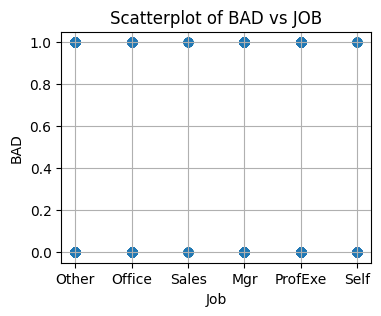

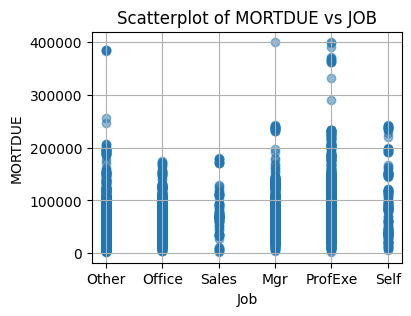

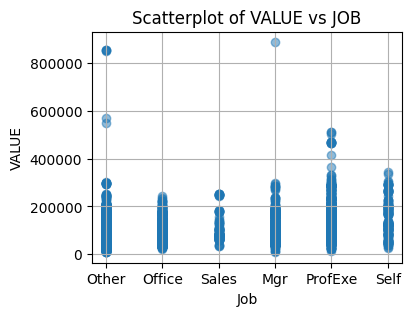

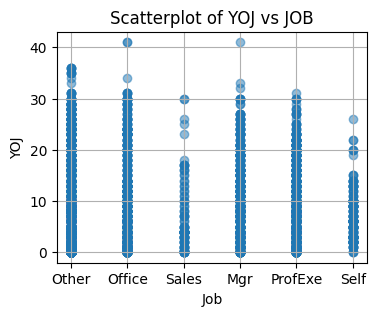

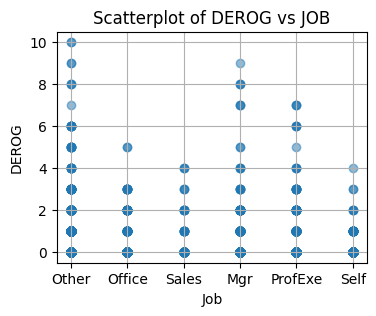

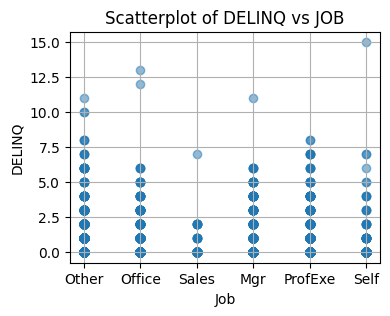

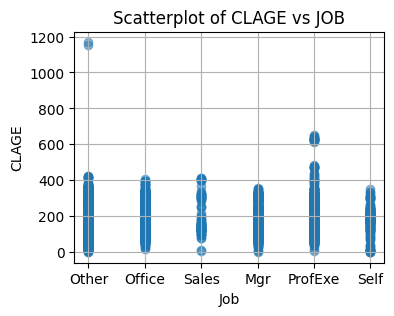

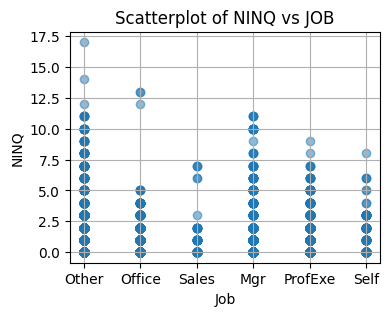

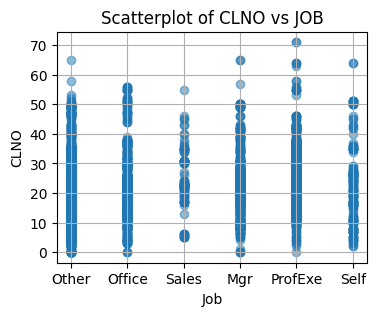

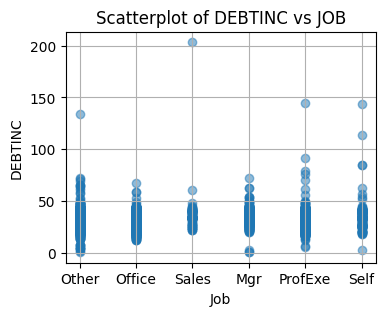

In [143]:
columns_to_plot = df.columns[df.columns != 'JOB']

# Plot scatterplots for each column against 'job'
for column in columns_to_plot:
    plt.figure(figsize=(4, 3))
    plt.scatter(df['JOB'], df[column], alpha=0.5)
    plt.title(f'Scatterplot of {column} vs JOB')
    plt.xlabel('Job')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()

In [144]:
df = pd.get_dummies(df, columns=['JOB'])

In [145]:
#if 'JOB_Other' in df.columns:
#    df.drop(columns=['JOB_Other'], inplace=True)

In [146]:
print(df.columns)

Index(['BAD', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC', 'JOB_Mgr', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe',
       'JOB_Sales', 'JOB_Self'],
      dtype='object')


In [147]:
dummy_variables = ['JOB_Mgr','JOB_Office','JOB_Other','JOB_ProfExe','JOB_Sales','JOB_Self']
df[dummy_variables] = df[dummy_variables].astype(int)

**Checking data after cleaning**

In [148]:
remaining_missing_values = df.isnull().sum().sum()

if remaining_missing_values == 0:
    print("No missing values remaining after data cleaning.")
else:
    print(f"There are {remaining_missing_values} missing values remaining after data cleaning.")

No missing values remaining after data cleaning.


## Outliers

In [149]:
columns_to_check_for_outliers = ['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
threshold = 3

outliers_count = {}
for col in columns_to_check_for_outliers:
    z_scores = stats.zscore(df[col])
    upper_outliers = df[col][z_scores > threshold]
    lower_outliers = df[col][z_scores < -threshold]
    total_outliers = len(upper_outliers) + len(lower_outliers)
    outliers_count[col] = total_outliers

num_rows_after_cleaning = df.shape[0]

print(f'The number of rows after data cleaning is: {num_rows_after_cleaning}')

print("Number of outliers in each column:")
for col, count in outliers_count.items():
    print(f"{col}: {count} outliers")


The number of rows after data cleaning is: 5680
Number of outliers in each column:
YOJ: 30 outliers
DEROG: 125 outliers
DELINQ: 167 outliers
CLAGE: 31 outliers
NINQ: 118 outliers
CLNO: 42 outliers
DEBTINC: 50 outliers


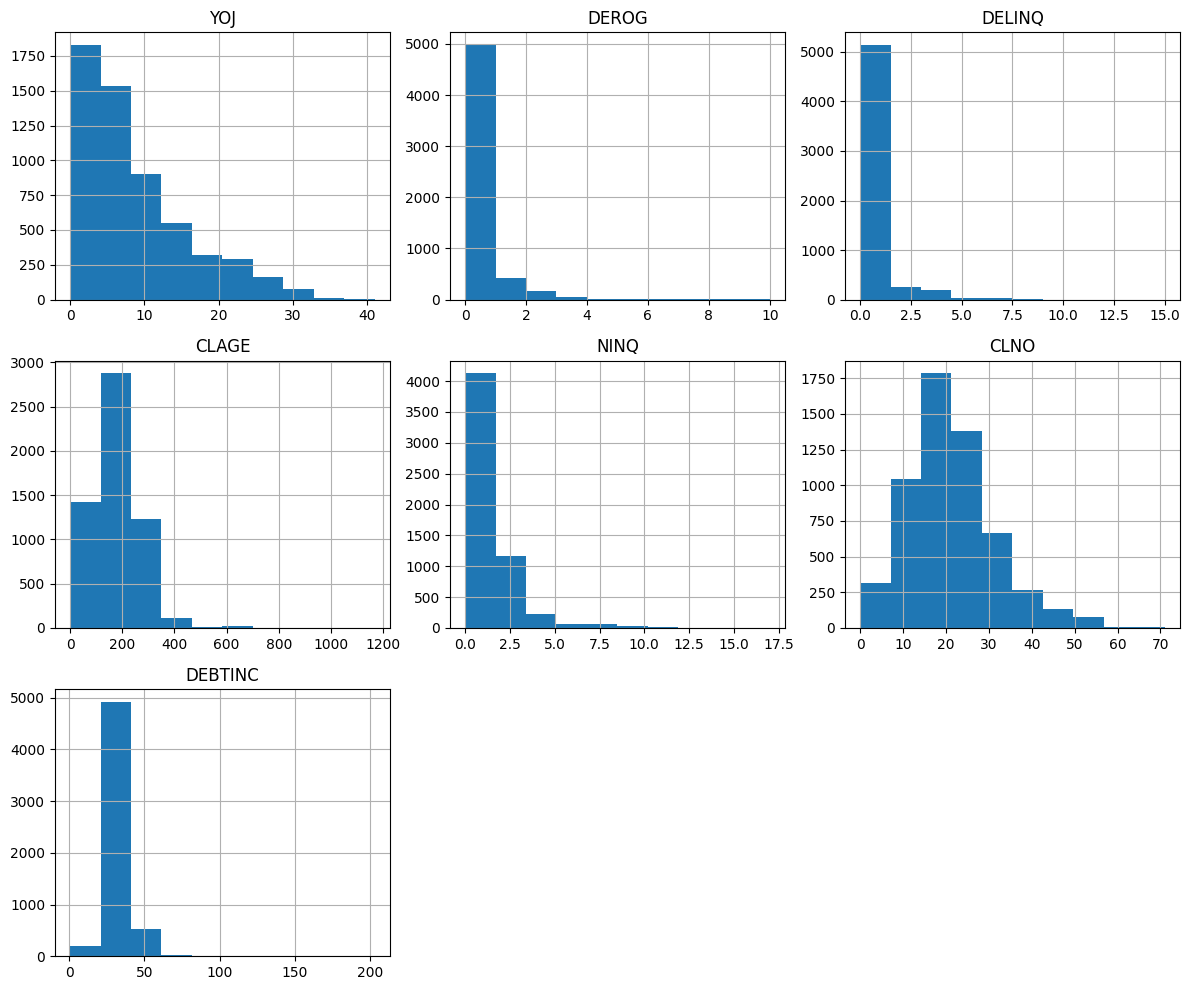

In [150]:
df[columns_to_check_for_outliers].hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

In [151]:
columns_to_check_for_outliers = ['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
threshold = 3

outliers_mask = np.zeros(len(df), dtype=bool)

for col in columns_to_check_for_outliers:
    z_scores = stats.zscore(df[col])
    outliers_mask |= np.abs(z_scores) > threshold

cleaned_df = df[~outliers_mask]

num_rows = cleaned_df.shape[0]
print("Number of rows in the DataFrame:", num_rows)


Number of rows in the DataFrame: 5180


In [152]:
num_rows_cleaned = cleaned_df.shape[0]

percentage_change = ((num_rows_cleaned - num_rows_raw) / num_rows_raw) * 100

print("Original number of rows: ", num_rows_raw)
print(f"Number of rows after cleaning: {num_rows_cleaned}")
print(f"Percentage change in number of rows: {round(percentage_change, 2)}%")

Original number of rows:  5960
Number of rows after cleaning: 5180
Percentage change in number of rows: -13.09%


In [153]:
check_after_cleaning = ['BAD']

for col in check_after_cleaning:
    unique_values = cleaned_df[col].unique()
    value_counts = cleaned_df[col].value_counts()
    percent = ((cleaned_df[col] == 1).sum()/cleaned_df[col].count())*100
    print(f"Column: {col}")
    print(f"Unique values: {unique_values}")
    print(f"Value counts:\n{value_counts}\n")
    print("Percent of default loans: {:.2f}%".format(percent))

Column: BAD
Unique values: [1 0]
Value counts:
BAD
0    4305
1     875
Name: count, dtype: int64

Percent of default loans: 16.89%


# Building a PD model

## Train and Test Data Sets

In [154]:
columns_to_drop = ['MORTDUE','VALUE']
cleaned_df2 = cleaned_df.drop(columns=columns_to_drop)

x = cleaned_df2.drop('BAD', axis=1)
y = cleaned_df2['BAD']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print("Original Dataset:")
print(cleaned_df['BAD'].value_counts(normalize=True) * 100)
print(cleaned_df['BAD'].value_counts())

print("\nTraining Dataset:")
print(y_train.value_counts(normalize=True) * 100)
print(y_train.value_counts())

print("\nTesting Dataset:")
print(y_test.value_counts(normalize=True) * 100)
print(y_test.value_counts())

Original Dataset:
BAD
0    83.108108
1    16.891892
Name: proportion, dtype: float64
BAD
0    4305
1     875
Name: count, dtype: int64

Training Dataset:
BAD
0    83.277027
1    16.722973
Name: proportion, dtype: float64
BAD
0    3451
1     693
Name: count, dtype: int64

Testing Dataset:
BAD
0    82.432432
1    17.567568
Name: proportion, dtype: float64
BAD
0    854
1    182
Name: count, dtype: int64


## Model training

In [155]:
model = sm.Logit(y_train, x_train)
logit_result = model.fit()

# Get the AIC value
aic = round((logit_result.aic),2)

print(logit_result.summary())
print("AIC:", aic)

Optimization terminated successfully.
         Current function value: 0.386309
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 4144
Model:                          Logit   Df Residuals:                     4131
Method:                           MLE   Df Model:                           12
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                  0.1443
Time:                        17:25:15   Log-Likelihood:                -1600.9
converged:                       True   LL-Null:                       -1870.9
Covariance Type:            nonrobust   LLR p-value:                6.629e-108
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
YOJ            -0.0225      0.007     -3.135      0.002      -0.037      -0.008
DEROG           0.6812    

Positive coefficients suggest a positive correlation with the likelihood of default and vice versa.

The pseudo R-squared value of approximately 0.1443 suggests that the model explains approximately 14.43% of the variability in the dependent variable.

In [156]:
# Function for backward elimination
def backward_elimination(x_train, y_train, threshold=0.05):

    # Fit the logistic regression model
    logit_model = sm.Logit(y_train, x_train)
    logit_result = logit_model.fit()

    # Iteratively remove attributes with high p-values
    while True:
        # Find the attribute with the highest p-value
        max_p_value = logit_result.pvalues.max()

        # If the highest p-value is above the threshold, remove the corresponding attribute
        if max_p_value > threshold:
            max_p_index = logit_result.pvalues.idxmax()
            x_train = x_train.drop(max_p_index, axis=1)
            print(f"\nRemoving '{max_p_index}' (p-value: {max_p_value})")
            logit_model = sm.Logit(y_train, x_train)
            logit_result = logit_model.fit()
        else:
            break

    return logit_result

# Call the backward elimination function
final_logit_result = backward_elimination(x_train, y_train)

# Get the AIC value
aic = round((final_logit_result.aic),2)

# Print the final summary of the model results
print("\nFinal Model Summary:")
print(final_logit_result.summary())
print("AIC:", aic)

Optimization terminated successfully.
         Current function value: 0.386309
         Iterations 7

Removing 'JOB_Sales' (p-value: 0.14697854365939667)
Optimization terminated successfully.
         Current function value: 0.386567
         Iterations 7

Final Model Summary:
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 4144
Model:                          Logit   Df Residuals:                     4132
Method:                           MLE   Df Model:                           11
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                  0.1438
Time:                        17:25:15   Log-Likelihood:                -1601.9
converged:                       True   LL-Null:                       -1870.9
Covariance Type:            nonrobust   LLR p-value:                2.635e-108
                  coef    std err          z      P>|z|      [0.025      0.975]
---------

In forecasting the PD, the interpretability is not the main focus, thus, we may disregard the multicolinearity and the statistical significance of the variables. We see that the stepwise method removed the statistically not significant factor, but it resulted in higher Akaike score and lower R-squared. Thus, the first model will be used.

## Model performance metrics

In [157]:
significant_factors = ['YOJ', 'DEROG', 'DELINQ','CLAGE','NINQ','CLNO', 'DEBTINC','JOB_Mgr','JOB_Office','JOB_Other','JOB_ProfExe','JOB_Sales','JOB_Self']

# Create a subset of significant factors
x_train_significant = x_train[significant_factors]

# Add a constant column
x_train_significant_with_const = sm.add_constant(x_train_significant)

# Predict classes
predicted_train = logit_result.predict(x_train_significant) > 0.5  # Assuming threshold of 0.5 for binary classification

# Calculate confusion matrix
conf_matrix_train = confusion_matrix(y_train, predicted_train)

# Print the confusion matrix
print("Confusion Matrix (Training Set):")
print(conf_matrix_train)

Confusion Matrix (Training Set):
[[3382   69]
 [ 595   98]]


In [158]:
# Calculate precision, recall, and accuracy for the training set
precision_train = round(((precision_score(y_train, predicted_train))*100),2)
recall_train = round(((recall_score(y_train, predicted_train))*100),2)
accuracy_train = round(((accuracy_score(y_train, predicted_train))*100),2)

# Print the performance metrics for the training set
print("Performance Metrics (Training Set):")
print("Accuracy:", accuracy_train, "%")
print("Precision:", precision_train, "%")
print("Recall:", recall_train, "%")

Performance Metrics (Training Set):
Accuracy: 83.98 %
Precision: 58.68 %
Recall: 14.14 %


Accuracy: Accuracy measures the overall correctness of the predictions, representing the proportion of correctly classified cases among all cases. In this case Accuracy: 83.98%

Precision: Precision measures the proportion of correctly identified positive cases among all cases identified as positive. In other words - the ratio of non-default loans predicted as such. Precision: 58.68%

Recall: Recall measures the proportion of correctly identified positive cases among all actual positive cases, indicating the model's ability to find all cases with default loans. Recall: 14.14%

## Model's Threshold

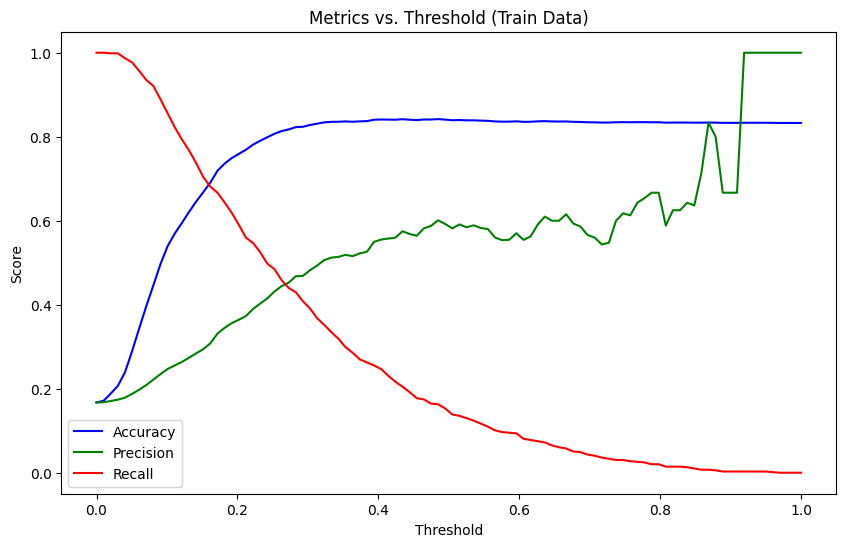

In [159]:
# Define thresholds
thresholds = np.linspace(0, 1, 100)

# Lists to store prediction metrics
accuracy_scores = []
precision_scores = []
recall_scores = []

# Calculate metric scores for each threshold
for threshold in thresholds:
    # Apply threshold to predicted probabilities
    predicted_classes_train = (logit_result.predict(x_train_significant) > threshold).astype(int)

    # Calculate accuracy, precision, and recall scores
    accuracy_train = accuracy_score(y_train, predicted_classes_train)
    precision_train = precision_score(y_train, predicted_classes_train, zero_division=1)
    recall_train = recall_score(y_train, predicted_classes_train)

    # Append scores to lists
    accuracy_scores.append(accuracy_train)
    precision_scores.append(precision_train)
    recall_scores.append(recall_train)

# Plot graphs
plt.figure(figsize=(10, 6))

plt.plot(thresholds, accuracy_scores, label='Accuracy', color='blue')
plt.plot(thresholds, precision_scores, label='Precision', color='green')
plt.plot(thresholds, recall_scores, label='Recall', color='red')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs. Threshold (Train Data)')
plt.legend(facecolor='white')
plt.show()

In this case, the cut-off was selected to prioritize reducing false negatives, as it's more critical to identify as many loans that will default as possible. For this reason, **a new cut-off of 0.2 was chosen.**

**Confusion matrix with 0.2 probability cut-off**

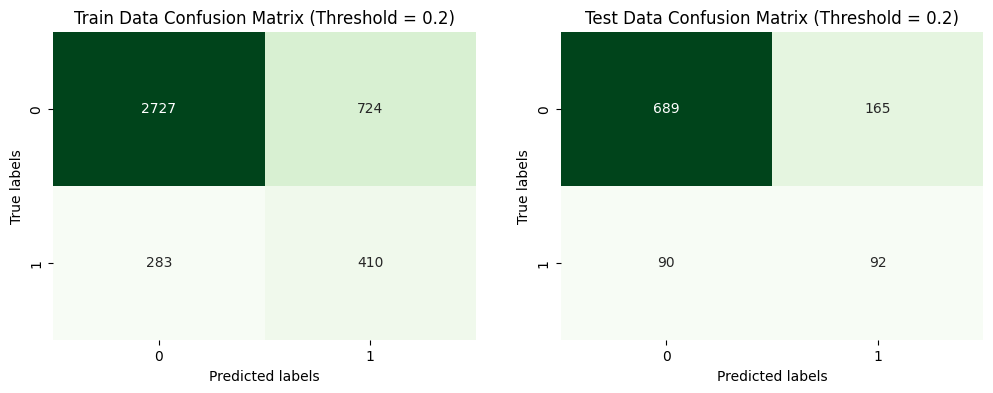

In [160]:
# significant_factors = ['YOJ', 'DEROG', 'DELINQ','CLAGE','NINQ','CLNO', 'DEBTINC']

# Create a subset of significant factors
x_train_significant = x_train[significant_factors]
x_test_significant = x_test[significant_factors]

threshold = 0.2

# Predict classes
predicted_probabilities_train = logit_result.predict(x_train_significant)
predicted_classes_train = (predicted_probabilities_train > threshold).astype(int)
predicted_probabilities_test = logit_result.predict(x_test_significant)
predicted_classes_test = (predicted_probabilities_test > threshold).astype(int)

# Calculate confusion matrix
conf_matrix_train = confusion_matrix(y_train, predicted_classes_train)
conf_matrix_test = confusion_matrix(y_test, predicted_classes_test)

# Plot confusion matrices
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Train Data Confusion Matrix (Threshold = 0.2)')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Test Data Confusion Matrix (Threshold = 0.2)')
plt.show()

In [161]:
# Calculate precision, accuracy, and recall for training and test sets
precision_train = round(precision_score(y_train, predicted_classes_train),4)*100
accuracy_train = round(accuracy_score(y_train, predicted_classes_train),4)*100
recall_train = round(recall_score(y_train, predicted_classes_train),4)*100

precision_test = round(precision_score(y_test, predicted_classes_test),4)*100
accuracy_test = round(accuracy_score(y_test, predicted_classes_test),4)*100
recall_test = round(recall_score(y_test, predicted_classes_test),4)*100

# Create a DataFrame to display the evaluation metrics
evaluation_metrics = pd.DataFrame({
    'Metric': ['Precision, %', 'Accuracy, %', 'Recall, %'],
    'Train Data': [precision_train, accuracy_train, recall_train],
    'Test Data': [precision_test, accuracy_test, recall_test]
})

# Display the DataFrame
print(evaluation_metrics)

         Metric  Train Data  Test Data
0  Precision, %       36.16      35.80
1   Accuracy, %       75.70      75.39
2     Recall, %       59.16      50.55


After testing the model with test data we see the model is performing well. Naturally it shows slightly lower performance metrics compared to train data, but the percent is close enough to consider the model is predicting similarly to the train data.

## ROC and AUC

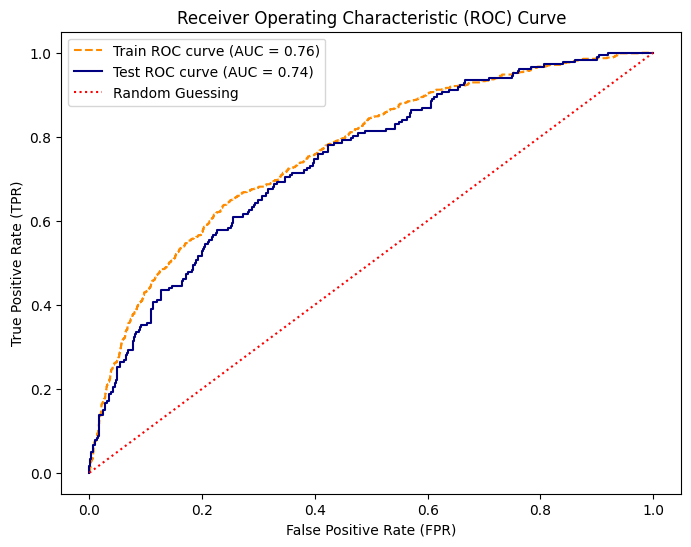

In [162]:
#train ROC curve
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, predicted_probabilities_train)
roc_auc_train = auc(fpr_train, tpr_train)

#test ROC curve
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, predicted_probabilities_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', linestyle='--', label='Train ROC curve (AUC = {:.2f})'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, color='navy', linestyle='-', label='Test ROC curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='red', linestyle=':', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(facecolor='white')
plt.show()

The ROC curve is similar to the performance metrics. With model performing slightly less well on the test data, but still with AUC 0.74 it is better than random guess.

# Standardized Approach

In calculating the risk weighted assets (RWA) by using the standardized approach the risk weights are given, so we need to classify loans and apply risk weights.

The given weights:
- 20% to loans with loan to value ratio (LTV) less of equal to 50%
- 25% for loans with LTV between 50 and 60%
- 30% for loans with LTV between 60 and 80%
- 40% for loans with LTV between 80 and 90%
- 50% for loans with LTV between 90 and 100%
- 70% for loans with LTV over 100%

In [163]:
sa_df = df[['BAD', 'MORTDUE']].copy()

sa_df = sa_df.rename(columns={'BAD': 'DEFAULT_FLAG', 'MORTDUE': 'EAD'})

sa_df['LTV'] = df['MORTDUE'] / df['VALUE']

rw_values = (
    pd.cut(sa_df['LTV'], bins=[-float('inf'), 0.5, 0.6, 0.8, 0.9, 1, float('inf')], labels=[0.2, 0.25, 0.3, 0.4, 0.5, 0.7])
)

sa_df['RW'] = rw_values.astype(float)

sa_df['RWA'] = sa_df['RW'] * sa_df['EAD']

sa_df

,DEFAULT_FLAG,EAD,LTV,RW,RWA
0,1,25860.0,0.662652,0.30,7758.00
1,1,70053.0,1.024167,0.70,49037.10
2,1,13500.0,0.808383,0.40,5400.00
4,0,97800.0,0.873214,0.40,39120.00
5,1,30548.0,0.757639,0.30,9164.40
...,...,...,...,...,...
5955,0,57264.0,0.634961,0.30,17179.20
5956,0,54576.0,0.587237,0.25,13644.00
5957,0,54045.0,0.581604,0.25,13511.25
5958,0,50370.0,0.548328,0.25,12592.50


Calculation for 8% capital requirement for non-default loans:

In [164]:
filtered_df_sa = sa_df[sa_df['DEFAULT_FLAG'] == 0]

total_EAD_sa = filtered_df_sa['EAD'].sum()
total_RWA_sa = filtered_df_sa['RWA'].sum()
capital_requirement_sa = total_RWA_sa * 0.08
risk_weight_sa = total_RWA_sa/total_EAD_sa

print('Total EAD: ', '${:,.2f}'.format(total_EAD_sa))
print('Total RWA: ', '${:,.2f}'.format(total_RWA_sa))
print('Risk weight of loan portfolio: ', '{:.2%}'.format(risk_weight_sa))
print('Capital requirement according to Basel III: ', '\033[1m${:,.2f}\033[0m'.format(capital_requirement_sa))

Total EAD:  $324,177,823.71
Total RWA:  $105,561,938.06
Risk weight of loan portfolio:  32.56%
Capital requirement according to Basel III:  $8,444,955.04


# F-IRB Approach

The loans we explore are residential mortgages, thus, the following formula applies when calculating capital requirement using the foundation internal rates based approach:

#CRE31_20220101_10.svg

Source: CRE31: IRB Approach: risk weight functions

Risk-weighted assets for retail exposures that are not in default:

https://www.bis.org/basel_framework/chapter/CRE/31.htm

In [165]:
# Create a subset of significant factors
x_significant = df[significant_factors]

# Predict classes
predicted_probabilities = logit_result.predict(x_significant)

predicted_probabilities

0       0.236194
1       0.485990
2       0.199392
4       0.097835
5       0.260917
          ...   
5955    0.085402
5956    0.093463
5957    0.092649
5958    0.087983
5959    0.084106
Length: 5680, dtype: float64

I will set each customer with a credit rating. I will use credit rating scores AAA, AA, A, BBB, BB, B, C and D.

In [166]:
dataframe = pd.DataFrame({'predicted_probability': predicted_probabilities})

def assign_credit_score(x):
    if x <= 0.125:
        return 'AAA'
    elif x <= 0.25:
        return 'AA'
    elif x <= 0.375:
        return 'A'
    elif x <= 0.5:
        return 'BBB'
    elif x <= 0.625:
        return 'BB'
    elif x <= 0.75:
        return 'B'
    elif x <= 0.875:
        return 'C'
    else:
        return 'D'

In [167]:
dataframe['predicted_rating'] = dataframe['predicted_probability'].apply(assign_credit_score)
dataframe

,predicted_probability,predicted_rating
0,0.236194,AA
1,0.485990,BBB
2,0.199392,AA
4,0.097835,AAA
5,0.260917,A
...,...,...
5955,0.085402,AAA
5956,0.093463,AAA
5957,0.092649,AAA
5958,0.087983,AAA


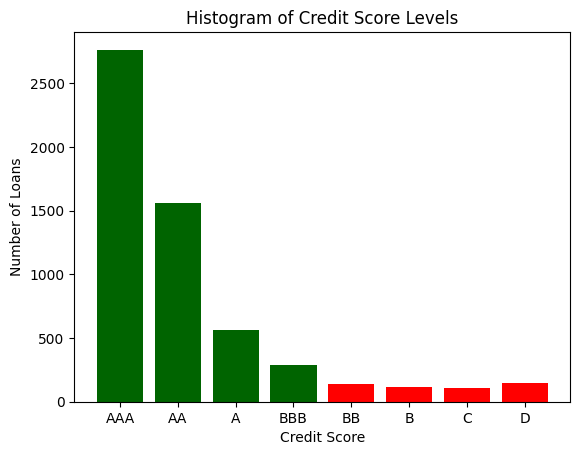

In [173]:
rating_counts = dataframe['predicted_rating'].value_counts()

custom_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'C', 'D']
rating_counts_sorted = rating_counts.reindex(custom_order)

colors = ['darkgreen'] * 4 + ['red'] * 4

# Plot the histogram
plt.bar(rating_counts_sorted.index, rating_counts_sorted.values, color=colors)

# Add labels and title
plt.xlabel('Credit Score')
plt.ylabel('Number of Loans')
plt.title('Histogram of Credit Score Levels')

# Show plot
plt.show()

We see from the loan distribution that the absolute majority (91%) of loans are of the highest grade (Investment grase as per Moody's, S&P and Fitch), meaning that they are of credit ratins AAA, AA, A, or BBB. Only a small part is of the Non-Investment Grade (BB, B, C and D).

In [169]:
firb_df = df[['BAD', 'MORTDUE']].copy()

firb_df = firb_df.rename(columns={'BAD': 'DEFAULT_FLAG', 'MORTDUE': 'EAD'})

firb_df['Y_forecast'] = predicted_probabilities

firb_df['LGD'] = 0.45

firb_df['R'] = 0.15

firb_df['K'] = (firb_df['LGD'] * norm.cdf(norm.ppf(firb_df['Y_forecast']) / ((1 - firb_df['R'])**0.5) + ((firb_df['R'] / (1 - firb_df['R']))**0.5) * norm.ppf(0.999)) - firb_df['Y_forecast'] * firb_df['LGD'])

firb_df['RWA'] = firb_df['EAD'] * 12.5 * firb_df['K']

firb_df

,DEFAULT_FLAG,EAD,Y_forecast,LGD,R,K,RWA
0,1,25860.0,0.236194,0.45,0.15,0.207824,67179.004792
1,1,70053.0,0.485990,0.45,0.15,0.184584,161633.028451
2,1,13500.0,0.199392,0.45,0.15,0.202376,34150.869342
4,0,97800.0,0.097835,0.45,0.15,0.162093,198158.542387
5,1,30548.0,0.260917,0.45,0.15,0.209685,80068.206717
...,...,...,...,...,...,...,...
5955,0,57264.0,0.085402,0.45,0.15,0.153120,109603.431034
5956,0,54576.0,0.093463,0.45,0.15,0.159084,108526.980676
5957,0,54045.0,0.092649,0.45,0.15,0.158506,107080.956958
5958,0,50370.0,0.087983,0.45,0.15,0.155091,97649.257688


Calculation for 8% capital requirement for non-default loans:

In [170]:
filtered_df_firb = firb_df[firb_df['DEFAULT_FLAG'] == 0]

total_EAD_firb = filtered_df_firb['EAD'].sum()
total_RWA_firb = filtered_df_firb['RWA'].sum()
capital_requirement_firb = total_RWA_firb * 0.08
risk_weight_firb = total_RWA_firb/total_EAD_firb

print('Total EAD: ', '${:,.2f}'.format(total_EAD_firb))
print('Total RWA: ', '${:,.2f}'.format(total_RWA_firb))
print('Risk weight of loan portfolio: ', '{:.2%}'.format(risk_weight_firb))
print('Capital requirement according to Basel III: ', '\033[1m${:,.2f}\033[0m'.format(capital_requirement_firb))

Total EAD:  $324,177,823.71
Total RWA:  $644,015,969.82
Risk weight of loan portfolio:  198.66%
Capital requirement according to Basel III:  $51,521,277.59


These calculations show that the capital requirement is ~ 8.5 mln. USD using Standardized Approach and over 51 mln. USD using Foundation IRB Approach (6 times the capital amount of the Standardized Approach).

Each of these approaches have their pros and cons. Strictly from business point of view, in terms of capital requirement, Standardized Approach has a benefit of requiring to keep significantly less capital available. Thus, it might be preferrable approach to evaluate this loan portfolio.

Standardized Approach provides simplified model frameworks that offer more flexibility and faster implementation. However, the model risk is increased with possibly inaccurate or misleading models being used to
inform management decisions.